# Build the response matrix from prep30

In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
# Select the file and the tree from which to generate the response matrix
files = "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/prep30/*.root"
workers = 45
step_size = "500 MB"

# Amount of bins and histogram limits
nbins, rmin, rmax = 50, 0.2, 1.8

In [3]:
# histograms to show the variables
invM      = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
matchedMC = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
# response matrix
R = bh.Histogram(
    bh.axis.Regular(nbins, rmin, rmax), bh.axis.Regular(nbins, rmin, rmax)
)

In [4]:
# variables to build the response matrix
leaves_to_use = ["tau_sig_matchedMC_InvM", "tau_sig_InvM", "nPi0s_sig"]
leaves_to_use += ["neutral_sig_mcPX", "neutral_sig_mcPY", "neutral_sig_mcPZ", "neutral_sig_mcE"]
leaves_to_use += ["track_sig_mcPX", "track_sig_mcPY", "track_sig_mcPZ", "track_sig_mcE"]
# variables to clean the data
leaves_to_use += ["track_sig_charge", "tauPlusMCMode", "tauMinusMCMode"]

for df in uproot.iterate(f"{files}:tau1x1", filter_name=leaves_to_use, step_size=step_size, num_workers=workers):
    # filter events with one pi0
    one_pi0 = df[ (df.nPi0s_sig == 1) ]
    # filter events that are signal
    signal = one_pi0[( 
        ( (one_pi0.track_sig_charge==1)  & (one_pi0.tauPlusMCMode ==4) ) | 
        ( (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode==4) )
    )]
    # build histograms
    invM.fill(signal.tau_sig_InvM)
    # compute invariant mass MC
    matchedMC.fill( np.sqrt(
        (signal.neutral_sig_mcE + signal.track_sig_mcE)**2
        - (signal.neutral_sig_mcPX + signal.track_sig_mcPX)**2 - (signal.neutral_sig_mcPY + signal.track_sig_mcPY)**2 - (signal.neutral_sig_mcPZ + signal.track_sig_mcPZ)**2)
    )
    # build response matrix (2D histogram)
    R.fill(signal.tau_sig_InvM, signal.tau_sig_matchedMC_InvM)

In [5]:
# save histograms
import pickle

with open("tau2pipi0nu_response_matrix.pkl", "wb") as f:
    container = {
        "truth" : matchedMC,
        "reco"  : invM,
        "R"     : R,
    }
    pickle.dump(container, f)

## Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from doc import plot_utils
plot_utils.setup()

with open("./data/tau2pipi0nu_response_matrix.pkl", 'rb') as f:
    container = pickle.load(f)
    matchedMC = container["truth"]
    invM = container["reco"]
    R = container["R"]

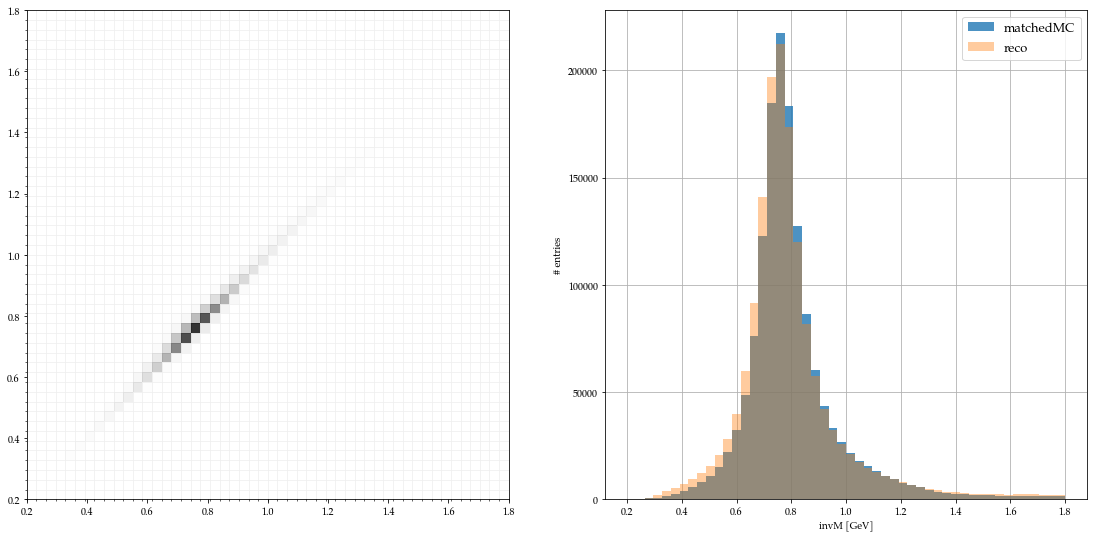

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(19, 9))
#fig.suptitle(f"Built from {files}")

# Plot the response matrix
axs[0].pcolormesh(*R.axes.edges.T, R.view().T, cmap="binary", alpha=0.8)
axs[0].set_xticks(R.axes.edges[0], minor=True)
axs[0].set_yticks(R.axes.edges[0], minor=True)
axs[0].xaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
axs[0].yaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
axs[0].grid(which="minor", alpha=1)

# Plot the histograms
axs[1].bar(matchedMC.axes[0].centers, matchedMC.view(), width=matchedMC.axes[0].widths, label="matchedMC", alpha=0.8)
axs[1].bar(invM.axes[0].centers, invM.view(), width=invM.axes[0].widths, label="reco", alpha=0.4)
#axs[1].grid()
axs[1].set_xlabel("invM [GeV]")
axs[1].set_ylabel("# entries")
axs[1].legend(prop={"size": 13})

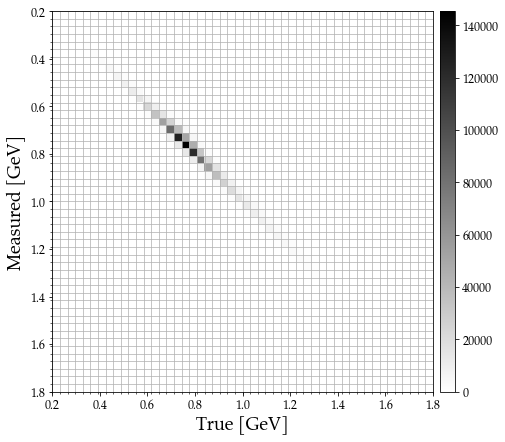

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plot_utils.get_1x1_im_figure()
r_ax = axs

# Plot the response matrix
divider = make_axes_locatable(r_ax)
cax = divider.append_axes('right', size='4%', pad=0.1)
min_edge = R.axes.edges[1][0][0]
max_edge = R.axes.edges[1][0][-1]
im = r_ax.imshow(R.view(), extent=[min_edge, max_edge, max_edge, min_edge], origin="upper",cmap="binary")
fig.colorbar(im, cax=cax, orientation="vertical")
r_ax.set_xticks(R.axes.edges[0], minor=True)
r_ax.set_yticks(R.axes.edges[0], minor=True)
r_ax.xaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
r_ax.yaxis.remove_overlapping_locs = False # fix overlapping minor/major ticks
r_ax.set_xlabel("True [GeV]")
r_ax.set_ylabel("Measured [GeV]")
r_ax.grid(which="minor", alpha=0.9)
r_ax.grid(which="major", alpha=0)
fig.savefig("./doc/images/response_matrix.svg", transparent=True)

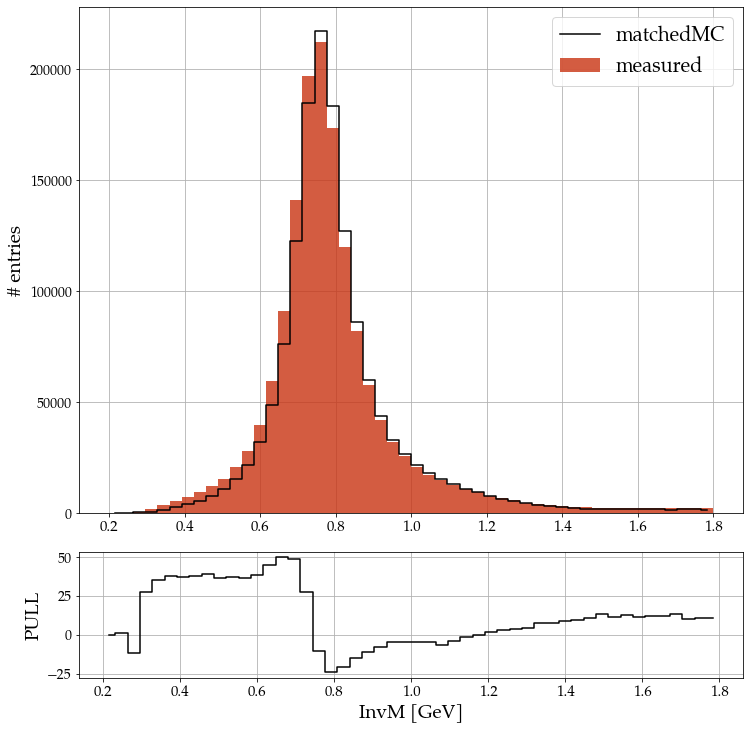

In [4]:
#fig, axs = plot_utils.get_1x1_im_figure(with_pull=True)
import matplotlib
matplotlib.rc("axes", titlesize=18)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=19)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=15)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=14)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=18)  # legend fontsize
fig, axs = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={"height_ratios": [8, 2]})
fig.tight_layout()

hax = axs[0]
# Plot the histograms
hax.step(matchedMC.axes[0].centers, matchedMC.view(), where="mid", label="matchedMC", color="black")
hax.bar(invM.axes[0].centers, invM.view(), width=invM.axes[0].widths, label="measured", alpha=0.8, color="#C93312")
hax.set_ylabel("# entries")
hax.legend(prop={"size": 20})

# PLot the pull
pax = axs[1]
error = np.sqrt(invM.view())
pull = np.divide(invM.view()-matchedMC.view(), error, where=(error!=0))
pax.step(matchedMC.axes[0].centers, pull, where="mid", color="black")
pax.set_ylabel("PULL")
pax.set_xlabel("InvM [GeV]")

fig.savefig("/home/peguerosdc/development/thesis/doc/images/response_histograms.svg", transparent=True)